# First pass at analyzing O2 dilution data

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pboc.plotting
import sys
sys.path.insert(0, '../../../')
import mwc_growth as mwc
import pandas as pd
import matlab.engine as matlab
import scipy.optimize
import glob
import seaborn as sns
eng = matlab.start_matlab()
colors = pboc.plotting.set_plotting_style()
%matplotlib inline

## Calculating the calibration factor.

In [97]:
# Define the data directory.
data_dir = '../../../data/images/20180117_37C_glucose_O2_dilution/'

# Grab the growth positions.
growth_pos = glob.glob('{0}20180117_growth*/xy*'.format(data_dir))

# Set up a list to store the resultant dataframes
dfs = []

# iterate through each position and load the cell files into python.
for i, pos in enumerate(growth_pos):
    
    # Load the cell files.
    cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
    
    # Parse each cell file and get a resulting dataframe.
    position = int(pos.split('/')[-1].split('xy')[1])
    _df = mwc.parse_cell_files(cell_files, eng=eng, add_props=dict(position=position))
   
    # Append to the storage list.
    dfs.append(_df)
    
# Concatenate into a single data frame.
growth_df = pd.concat(dfs, ignore_index=True)

In [98]:
growth_df

,ID,birth,birth_area,daughter_1_ID,daughter_2_ID,death,death_area,divide,fluor1_birth_fluo,fluor1_death_fluo,fluor1_num_exposures,motherID,position,sisterID
0,117.0,23.0,390.0,NaN,NaN,24.0,390.0,0.0,28401.0,28401.0,NaN,65.0,16.0,118.0
1,103.0,21.0,386.0,NaN,NaN,24.0,386.0,0.0,32173.0,32173.0,NaN,21.0,16.0,102.0
2,88.0,19.0,427.0,NaN,NaN,24.0,427.0,0.0,34886.0,34886.0,NaN,24.0,16.0,89.0
3,63.0,9.0,637.0,NaN,NaN,24.0,637.0,0.0,46806.0,46806.0,NaN,50.0,16.0,64.0
4,77.0,14.0,932.0,80.0,81.0,15.0,994.0,1.0,0.0,0.0,0.0,0.0,16.0,0.0
5,76.0,14.0,503.0,NaN,NaN,24.0,503.0,0.0,36669.0,36669.0,NaN,41.0,16.0,75.0
6,62.0,8.0,347.0,111.0,112.0,22.0,713.0,1.0,0.0,0.0,0.0,27.0,16.0,61.0
7,89.0,19.0,471.0,NaN,NaN,24.0,471.0,0.0,38621.0,38621.0,NaN,24.0,16.0,88.0
8,102.0,21.0,363.0,NaN,NaN,24.0,363.0,0.0,29669.0,29669.0,NaN,21.0,16.0,103.0
9,116.0,23.0,567.0,NaN,NaN,24.0,567.0,0.0,47121.0,47121.0,NaN,92.0,16.0,115.0


In [99]:
# Load the other data sets.
other_sets = glob.glob('{0}/*snaps*/'.format(data_dir))
desired_props = ['fluor1_birth_fluo', 'fluo2_birth_fluo', 'birth_area']
excluded_props = [f for f in growth_df.keys() if f not in desired_props]
excluded_props.append('fluor2_death_fluo')
dfs = []
for i, samp in enumerate(other_sets):
    # Get the identity of the sample.
    _, _, strain, atc, _ = samp.split('/')[-2].split('_')
    atc = atc.split('ngmL')[0]
    
    # Get all of the positions in each folder.
    positions = glob.glob('{0}/xy*/'.format(samp))
    
    # Loop through each position.
    for j, pos in enumerate(positions):
        # Get a list of all cell files.
        cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
        
        # Parse them and exclude properties
        _df = mwc.parse_cell_files(cell_files, eng=eng, add_props=dict(position=j, strain=strain, atc=atc),
                                   excluded_props=excluded_props)
        dfs.append(_df)
        
snap_df = pd.concat(dfs, ignore_index=True)

In [100]:
# Find the mean autofluorescence value. 
auto_strain = snap_df[snap_df['strain']=='autofluorescence']
mean_auto_cherry = np.mean(auto_strain['fluor1_birth_fluo'] / auto_strain['birth_area'])
mean_auto_yfp = np.mean(auto_strain['fluor2_birth_fluo'] / auto_strain['birth_area'])

Computing the triads is easier this time as we have just one snap at the end with a fluorescence image. 

In [101]:
# Find the max frame.
max_frame = np.sort(growth_df['death'].unique())[-1]
measured = growth_df[(growth_df['death']==max_frame) & (growth_df['motherID']!=0)]

# Set the storage vectors.
I_1, I_2, summed, sq_diff = [], [], [], []

# Group the data by mother ID
grouped = measured.groupby(['position', 'motherID'])
for g, d in grouped:
    if len(d) == 2:
        daughters = d['fluor1_death_fluo'].values
        I_1.append(daughters[0])
        I_2.append(daughters[1])
        summed.append(daughters.sum())
        sq_diff.append(np.diff(daughters)[0]**2)

I_1 = np.array(I_1)
I_2 = np.array(I_2)
I_tot = I_1 + I_2

In [102]:
def deterministic_log_posterior(alpha, I_1, I_2, I_tot, neg=True):
    """
    Computes the log posterior of the deterministic solution to the estimation of the 
    calibration factor value.
    
    Parameters
    ----------
    alpha : float 
        The value of the calibration factor.
    I_1, I_2, I_tot : 1d-arrays or Pandas Series
        The intensity measurements of the daughter cells and the mother cell for a series of division events.
    neg : bool
        If True, the negative log posterior is returned. Default is True.
    
    Returns
    -------
    lp : float
        Value of the log posterior evaluated at the given value of alpha.
    """
    # Determine if the negative log posterior should be returned.
    if neg is True:
        prefactor = -1
    else: 
        prefactor = 1
    # Ensure that the intensity values are not negative.
    if (I_1 <= 0).any() or (I_2 <= 0).any() or (I_tot <= 0).any():
        return ValueError('I_1 and I_2 must be positive.')
    
    # Ensure that alpha is positive.
    if (alpha < 0) | (alpha > 2**16):
        return prefactor * -np.inf
    
    
    # Compute the binomial coefficient.
    n_1 = I_1 / alpha 
    n_2 = I_2 / alpha
    n_tot = I_tot / alpha
    binom = scipy.special.gammaln(n_tot+1).sum() - scipy.special.gammaln(n_1+1).sum() -\
            scipy.special.gammaln(n_2+1).sum()
 
    # Compute the log posterior.
    lp = -len(I_1) * np.log(alpha) + binom - n_tot.sum() * np.log(2)
     
    return prefactor * lp

In [103]:
#  Calculate the calibration factor.
popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(I_1, I_2, I_tot))
alpha_opt = popt.x
print(alpha_opt)

899.017066091


In [104]:
I_2

array([  39991.,   39523.,   49727.,   48516.,   42531.,   32388.,
         52137.,   49682.,   38696.,   33601.,   21765.,   27173.,
         25906.,   30838.,   20619.,   24709.,   23869.,   31644.,
         26175.,   32444.,   21288.,   22268.,   21275.,   69642.,
         29747.,   27441.,   46884.,   27656.,   26746.,   44722.,
         39404.,   28045.,   27539.,   20321.,   29683.,   34566.,
         50365.,   34248.,   57264.,   36261.,   53055.,   53711.,
         84322.,   58043.,   59544.,   63450.,   46465.,   46319.,
         53487.,   16652.,   29714.,   26072.,   32206.,   30886.,
         31480.,   34128.,   36613.,   27727.,   23968.,   47944.,
         44397.,   28390.,   28186.,   45920.,   20124.,   32648.,
         47601.,   34187.,   49766.,   53501.,   26774.,   33448.,
         25466.,   30121.,   26095.,   14002.,   46896.,   30355.,
         32297.,   49674.,   33613.,   34637.,   56032.,   47623.,
         30058.,   47926.,   32800.,   25193.,   30897.,   255

In [105]:
# Bin the data for plotting.
def binning_mean(data, bin_width, sort_values=False):
    """
    Computes the mean value of squared difference and summed intensity of the 
    supplied data with a given number of events per bin. 
    
    Parameters
    ----------
    data : pandas DataFrame
        A dataframe containing the intensities of the daughter cells and the sum
        total intensity.
    bin_width : int
        Number of events to consider per bin.
    sort_values : bool
        If True, the supplied data will be sorted in increasing order of the 
        sum total fluorescence. Default is False.
        
    Returns
    -------
    mean_sq_diff, mean_sum : 1d-arrays
        Arrays of the mean square difference value and the mean summed intensity 
        in a given bin width.  
    """
    # Sort the data if necessary.
    if sort_values:
        data = data.sort_values(by='I_tot')
        
    # Set the bins. 
    bins = np.arange(0, len(data) + bin_width, bin_width)
    
    # Compute the means. 
    mean_sq_diff = [np.mean((data.iloc[bins[i-1]:bins[i]+1]['I_1'] -\
                         data.iloc[bins[i-1]:bins[i]+1]['I_2'])**2) for i in range(1, len(bins))]
    mean_I_tot = [data.iloc[bins[i-1]:bins[i]+1]['I_tot'].mean() for i in range(1, len(bins))] 
    return [np.array(mean_sq_diff), np.array(mean_I_tot)] 

In [117]:
# Set up the data frame.
binning_df = pd.DataFrame(np.array([I_1, I_2, I_tot]).T, columns=['I_1', 'I_2', 'I_tot'])

# Bin the data. 
bin_size = 75 
mean_sq_diff, mean_I_tot = binning_mean(binning_df, bin_width=bin_size, sort_values=True)

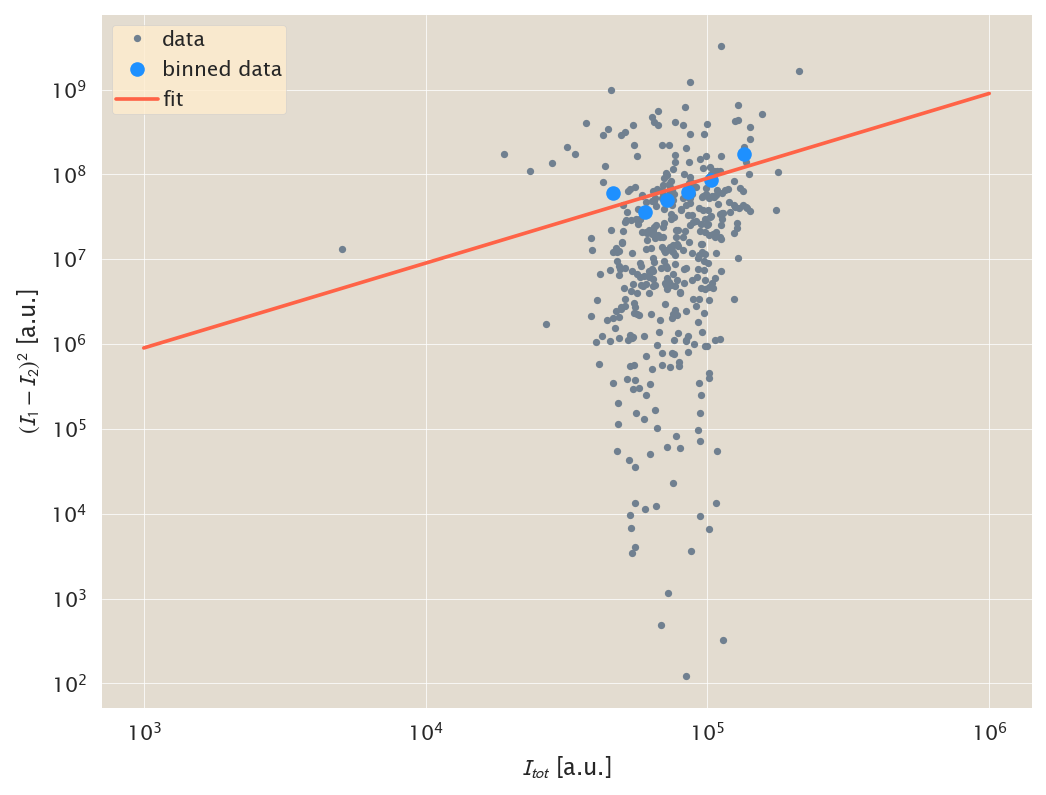

In [118]:
# Make the scatter plot.
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{tot}$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')

# Plot the data
_ = ax.plot(summed, sq_diff, '.', color='slategray', label='data')

# Plot the binned data.
_ = ax.plot(mean_I_tot, mean_sq_diff, 'o', color='dodgerblue', label='binned data')

# Plot the theory curve. 
I_tot_range = np.logspace(3, 6, 500)
theo = alpha_opt * I_tot_range
_ = ax.plot(I_tot_range, theo, '-', color='tomato', label='fit')

_ = ax.legend()

## Testing the calibration factor. 

In [108]:
def ecdf(data):
    return np.sort(data), np.arange(0, len(data), 1) / len(data)

That all makes sense

In [111]:
# Subtract the autofluorescence from each channel.
snap_df.loc[:, 'fluor2_sub'] = snap_df['fluor2_birth_fluo']
snap_df.loc[:, 'fluor1_sub'] = snap_df['fluor1_birth_fluo']

# Compute the mean delta for each.
mean_delta_yfp = snap_df[snap_df['strain']=='deltaLacI']['fluor2_sub'].mean()
mean_delta_cherry = snap_df[snap_df['strain']=='deltaTetR']['fluor1_sub'].mean()

# Look at only the dilution strain and calculate the fold change.
dilution_strain = snap_df[snap_df['strain']=='dlution']
fold_change = []
repressors = []
grouped = dilution_strain.groupby('atc')
for g, d in grouped:
    mean_yfp = d['fluor2_sub'].mean()
    fold_change.append(mean_yfp / mean_delta_yfp)
    mean_repressors = np.mean(d['fluor1_sub'] / alpha_opt)
    repressors.append(mean_repressors)

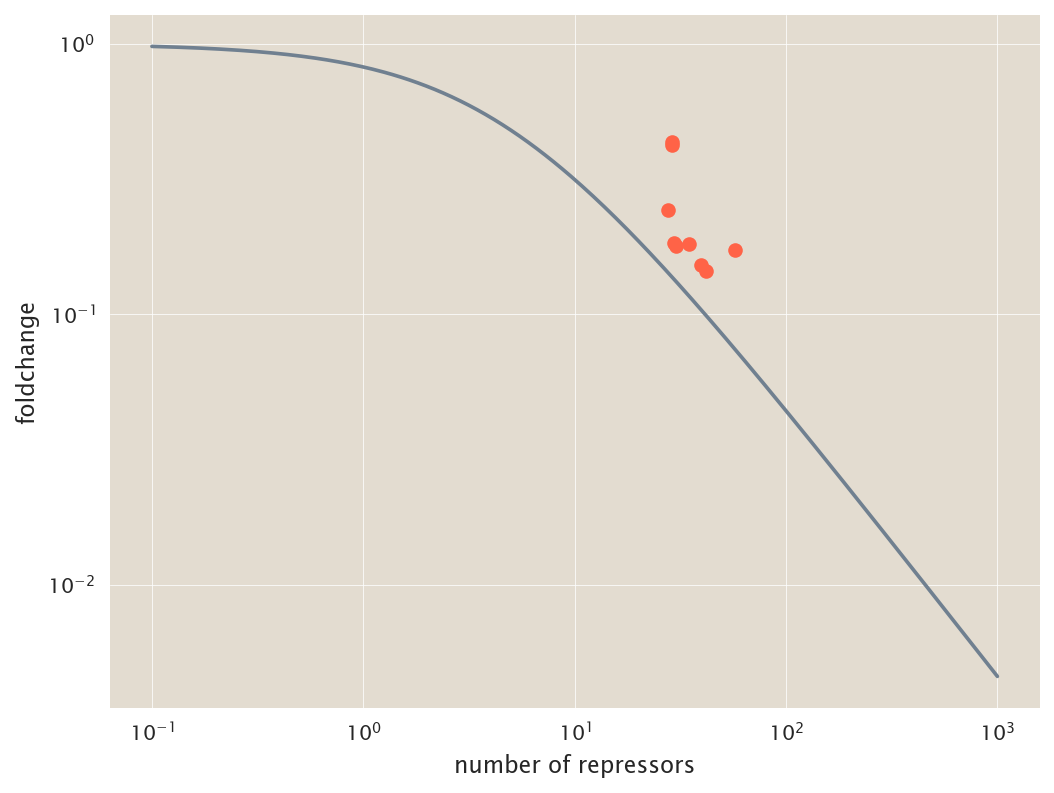

In [120]:
# Compute the prediction.
rep_range = np.logspace(-1, 3, 300)
fc_theo = (1 +  (rep_range / 5E6) * np.exp(13.9))**-1

# Generate the plot
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('number of repressors')
ax.set_ylabel('foldchange')
all_fc = dilution_strain['fluor2_sub'] / mean_delta_yfp
all_rep = dilution_strain['fluor1_sub'] / alpha_opt
# Plot the prediction.
_ = ax.plot(rep_range, fc_theo, color='slategray', label='theory')

# Plot the data
_ = ax.plot(np.array(repressors), fold_change, 'o', color='tomato', label='data')
# _ = ax.plot(all_rep, all_fc, ',', color='dodgerblue')


In [114]:
repressors

[28.980006034005203,
 29.006581463557108,
 27.50145687140504,
 41.65243965964611,
 29.47818170457314,
 30.22892998218298,
 34.759879839328356,
 39.79630439467961,
 57.28138469303119]